## Import, scale and sliding window the data

In [1]:
# Need 70Gb memory to run this as peaks at just over 60gb RAM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from useful_funcs import parse_data_dfs, make_timeseries
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import sys
import absl.logging

# ignore errors later when saving
# https://stackoverflow.com/questions/65697623/tensorflow-warning-found-untraced-functions-such-as-lstm-cell-6-layer-call-and
absl.logging.set_verbosity(absl.logging.ERROR)

di_df, pi_df, ti_df, dp_df, pp_df, tp_df = parse_data_dfs()
imperfect_final_rivs, perfect_final_rivs = list(di_df), list(dp_df)

print('Collected all base dataframes')
train_rivs, validate_rivs = train_test_split(
    imperfect_final_rivs, test_size=0.33, random_state=42)

dtrain_df = di_df.loc[:, train_rivs]
ptrain_df = pi_df.loc[:, train_rivs]
ttrain_df = ti_df.loc[:, train_rivs]

2022-12-06 20:09:08.204534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 20:09:08.588306: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Collected all base dataframes


In [2]:
from sklearn.preprocessing import StandardScaler
depth_mean, depth_std = dtrain_df.to_numpy().reshape(-1).mean(), dtrain_df.to_numpy().reshape(-1).std()
precip_mean, precip_std = ptrain_df.to_numpy().reshape(-1).mean(), ptrain_df.to_numpy().reshape(-1).std()
temp_mean, temp_std = ttrain_df.to_numpy().reshape(-1).mean(), ttrain_df.to_numpy().reshape(-1).std()
def undo_depth(x):
    return x*depth_std + depth_mean

In [3]:
from tqdm import tqdm

for col in tqdm(imperfect_final_rivs):
    di_df[col] = (di_df[col] - depth_mean)/ depth_std
    pi_df[col] = (pi_df[col] - precip_mean) / precip_std
    ti_df[col] = (ti_df[col] - temp_mean) / temp_std
for col in tqdm(perfect_final_rivs):
    dp_df[col] = (dp_df[col] - depth_mean)/ depth_std
    pp_df[col] = (pp_df[col] - precip_mean) / precip_std
    tp_df[col] = (tp_df[col] - temp_mean) / temp_std

100%|██████████| 36/36 [00:00<00:00, 1179.96it/s]


In [4]:
print('Transforming dataframes into timeseries dataframe')
data_days = 49
future_days = 14
rivers_to_consider = 1816  # up to 1816 rivers but will be slower


def slide_window_riv(riv):
    rolling_period = data_days+future_days
    imp = riv in list(di_df)
    d = di_df[riv].rolling(
        rolling_period) if imp else dp_df[riv].rolling(rolling_period)
    p = pi_df[riv].rolling(
        rolling_period) if imp else pp_df[riv].rolling(rolling_period)
    t = ti_df[riv].rolling(
        rolling_period) if imp else tp_df[riv].rolling(rolling_period)
    all_features = []

    # sliding window through depth, pressure and temp
    for idx, (rd, rp, rt) in enumerate(zip(d, p, t)):
        # rolling window initially not full
        if len(rd) != rolling_period:
            continue
        # https://stats.stackexchange.com/questions/35304/how-to-standardize-an-array-if-standard-deviation-is-zero
        rd_d = rd.values[:data_days]
        # rd_m, rd_std = np.mean(rd_d), np.std(rd_d) if np.std(rd_d) != 0 else 1
        rd_min, rd_max, rd_median = np.min(rd_d), np.max(rd_d), np.median(rd_d) if np.median(rd_d) != 0 else 1
        rd_denom = (rd_max - rd_min) if (rd_max - rd_min) != 0 else 1

        rp_d = rp.values[:data_days]
        # rp_m, rp_std = np.mean(rp_d), np.std(rp_d) if np.std(rp_d) != 0 else 1
        rp_min, rp_max = np.min(rp_d), np.max(rp_d)
        rp_denom = (rp_max - rp_min) if (rp_max - rp_min) != 0 else 1

        rt_d = rt.values[:data_days]
        # rt_m, rt_std = np.mean(rt_d), np.std(rt_d) if np.std(rt_d) != 0 else 1
        rt_min, rt_max = np.min(rt_d), np.max(rt_d)
        rt_denom = (rt_max - rt_min) if (rt_max - rt_min) != 0 else 1

        feature_data = np.concatenate((rd_d, rp_d, rt_d))
        # feature_data = np.concatenate(
        #     ((rd_d-rd_m)/rd_std, (rp_d-rp_m)/rp_std, (rt_d-rt_m)/rt_std))
        # feature_data = np.concatenate(
        #     ((rd_d-rd_min)/rd_denom, (rp_d-rp_min)/rp_denom, (rt_d-rt_min)/rt_denom))
        features = [rd.values[-1], riv, idx] + list(feature_data)
        # features = [(rd.values[-1]-rd_min)/rd_denom, riv, idx] + list(feature_data)
        all_features.append(features)
    return all_features


all_rivs = list(di_df) + list(dp_df)
X_train_df, X_val_df, X_test_df = make_timeseries(
    all_rivs[:rivers_to_consider], train_rivs, validate_rivs, slide_window_riv, data_days)
X_train_df['year_sin'] = np.sin(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_train_df['year_cos'] = np.cos(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_sin'] = np.sin(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_cos'] = np.cos(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_sin'] = np.sin(X_test_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_cos'] = np.cos(X_test_df['river_day'] * (2 * np.pi / 365.2425))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_df.iloc[:, 3:], X_train_df.iloc[:, [0]])).cache()
train_dataset = train_dataset.shuffle(60000).batch(20000).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_df.iloc[:, 3:], X_val_df.iloc[:, [0]])).cache()
validation_dataset = validation_dataset.shuffle(60000).batch(20000).prefetch(tf.data.AUTOTUNE)

Transforming dataframes into timeseries dataframe


Reassigning river data to correct frame: 100%|██████████| 1816/1816 [00:58<00:00, 30.78it/s]


Training data made
Training data sorted
Validation data made
Validation data sorted
Test data made
Test data sorted


2022-12-06 20:20:59.916115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from matplotlib.offsetbox import AnchoredText
from tensorflow.keras.models import load_model

# https://towardsdatascience.com/custom-loss-function-in-tensorflow-eebcd7fed17a,
mae = tf.keras.losses.MeanAbsoluteError()
class DepthMeanAbsoluteErrorLoss(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    return mae(undo_depth(y_true),undo_depth(y_pred))

stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)

def error_graph(model_name, history, cp_name):
    fig, ax = plt.subplots(1,1)
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    plt.title(f'{model_name} loss (Mean Absolute Error)')
    plt.ylabel('Loss (Mean Absolute Error in depth prediction)')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object/
    m = load_model(cp_name, custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})
    final_train_loss, final_val_loss, final_test_loss = m.evaluate(train_dataset), m.evaluate(validation_dataset), m.evaluate(X_test_df.iloc[:, 3:], X_test_df['y'])
    anchored_text = AnchoredText(f'Final train loss: {final_train_loss:.3f}ft\nFinal validation loss: {final_val_loss:.3f}ft\nFinal test loss: {final_test_loss:.3f}ft', loc=1)
    ax.add_artist(anchored_text)
    plt.savefig(f'./presentation docs/error_change_{model_name}.png', dpi=200)
    plt.show()

## Training, Validation, Test data description

In [ ]:
print(f'Training data has:   {len(X_train_df):,d} samples')
print(f'Validation data has: {len(X_val_df):,d} samples')
print(f'Test data has:       {len(X_test_df):,d} samples')

In [6]:
gc.collect()
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

tot_size = sizeof_fmt(sum([sys.getsizeof(value) for name, value in globals().items()]))
print(f'Current total size of variables is {tot_size} ... who knows what rest is!')

Current total size of variables is 8.0 GiB ... who knows what rest is!


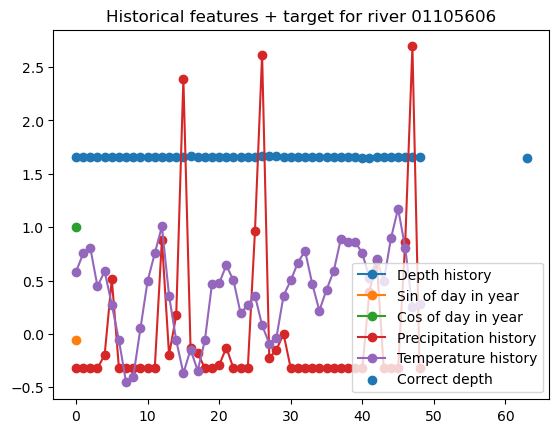

In [7]:
# What input and prediction looks like looks like
rowIdx = 300
y_point = X_train_df.iloc[rowIdx, :]['y']
all_ds = [f'd{idx}' for idx in range(data_days)]
all_ps = [f'p{idx}' for idx in range(data_days)]
all_ts = [f't{idx}' for idx in range(data_days)]
d_points = X_train_df.iloc[rowIdx, :][all_ds].to_list()
p_points = X_train_df.iloc[rowIdx, :][all_ps].to_list()
t_points = X_train_df.iloc[rowIdx, :][all_ts].to_list()
sin = X_train_df.iloc[rowIdx, :]['year_sin']
cos = X_train_df.iloc[rowIdx, :]['year_cos']
plt.plot(range(data_days), d_points, '-o', label='Depth history')
plt.plot(0,sin, '-o', label='Sin of day in year')
plt.plot(0,cos, '-o', label='Cos of day in year')
plt.plot(range(data_days), p_points, '-o', label='Precipitation history')
plt.plot(range(data_days), t_points, '-o', label='Temperature history')
plt.scatter(data_days + future_days, y_point, label='Correct depth')
plt.legend()
riv_name = X_train_df.iloc[rowIdx, :]['river']
plt.title(f'Historical features + target for river {riv_name}')
plt.savefig(f'./presentation docs/feature_prediction_example.png', dpi=200)
plt.show()

## Baseline Lasso model

In [7]:
from sklearn import linear_model
# --- LASSO model ---
lasso = linear_model.Lasso(alpha=0.1)
lasso = lasso.fit(X_train_df.iloc[:, 3:], X_train_df['y'])
score = lasso.score(X_val_df.iloc[:, 3:], X_val_df['y'])
print('R2 score for linear regression model:', score)

/home/tmd4/.conda/envs/mlwaterlevel/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.087e+03, tolerance: 4.282e+02
  model = cd_fast.enet_coordinate_descent(


R2 score for linear regression model: 0.9891428351245708


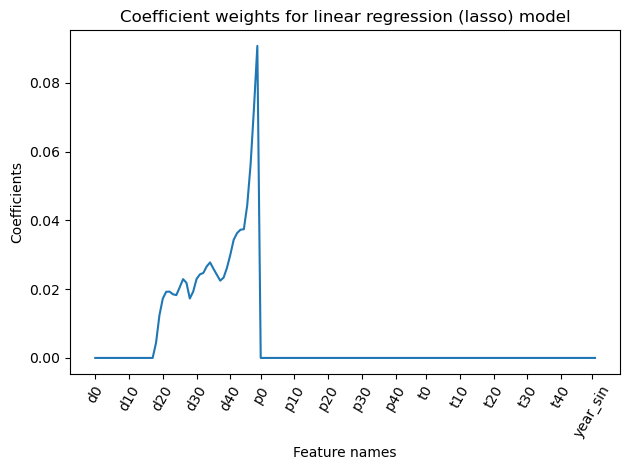

In [92]:
fig, ax = plt.subplots()
plt.plot(lasso.coef_)
ticks = [0,10,20,30,40, 49,59,69,79,89, 98,108,118,128,138, 147]
names = [list(X_train_df)[3:][t] for t in ticks]
plt.xticks(ticks, names, rotation = 60,horizontalalignment='center')
plt.ylabel('Coefficients')
plt.xlabel('Feature names')
plt.title(f'Coefficient weights for linear regression (lasso) model')
plt.tight_layout()
plt.savefig('./presentation docs/coefficients_lasso.png', dpi=200)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
pred = lasso.predict(X_train_df.iloc[:, 3:])
mean_abs_err = mean_absolute_error(undo_depth(X_train_df['y']), undo_depth(pred))
print(f'Mean abs error train: {mean_abs_err:.4f} ft')
pred = lasso.predict(X_val_df.iloc[:, 3:])
mean_abs_err = mean_absolute_error(undo_depth(X_val_df['y']), undo_depth(pred))
print(f'Mean abs error validation: {mean_abs_err:.4f} ft')
pred = lasso.predict(X_test_df.iloc[:, 3:])
mean_abs_err = mean_absolute_error(undo_depth(X_test_df['y']), undo_depth(pred))
print(f'Mean abs error test: {mean_abs_err:.4f} ft')

## D48

In [90]:
from sklearn.metrics import mean_absolute_error
pred = X_train_df.iloc[:, 3+48].to_numpy().reshape(-1)
mean_abs_err = mean_absolute_error(undo_depth(X_train_df['y']), undo_depth(pred))
print(f'Mean abs error train: {mean_abs_err:.4f} ft')
pred = X_val_df.iloc[:, 3+48].to_numpy().reshape(-1)
mean_abs_err = mean_absolute_error(undo_depth(X_val_df['y']), undo_depth(pred))
print(f'Mean abs error validation: {mean_abs_err:.4f} ft')
pred = X_test_df.iloc[:, 3+48].to_numpy().reshape(-1)
mean_abs_err = mean_absolute_error(undo_depth(X_test_df['y']), undo_depth(pred))
print(f'Mean abs error test: {mean_abs_err:.4f} ft')

Mean abs error train: 0.9321 ft
Mean abs error validation: 0.8922 ft
Mean abs error test: 0.7745 ft


## Baseline single neuron model

In [11]:
input_shape = np.array(X_val_df.columns[3:]).shape
print(f'Input shape is: {input_shape}')

Input shape is: (149,)


In [12]:
# Baseline model
model = Sequential([
    Dense(1, input_shape=input_shape)
])

model.compile(loss=DepthMeanAbsoluteErrorLoss(),
              optimizer=tf.keras.optimizers.Adam())
cp_singleneuron = ModelCheckpoint('singleneuron/', save_best_only=True)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, shuffle=True, 
                    callbacks=[cp_singleneuron, stop_early])

Epoch 1/50
215/215 [==============================] - 24s 109ms/step - loss: 10.2976 - val_loss: 2.4679
Epoch 2/50
215/215 [==============================] - 14s 58ms/step - loss: 1.6559 - val_loss: 1.1489
Epoch 3/50
215/215 [==============================] - 14s 60ms/step - loss: 1.0943 - val_loss: 0.9888
Epoch 4/50
215/215 [==============================] - 14s 59ms/step - loss: 1.0488 - val_loss: 0.9698
Epoch 5/50
215/215 [==============================] - 14s 61ms/step - loss: 1.0272 - val_loss: 0.9706
Epoch 6/50
215/215 [==============================] - 14s 60ms/step - loss: 1.0266 - val_loss: 0.9768
Epoch 7/50
215/215 [==============================] - 14s 61ms/step - loss: 1.0129 - val_loss: 0.9616
Epoch 8/50
215/215 [==============================] - 14s 59ms/step - loss: 1.0012 - val_loss: 0.9458
Epoch 9/50
215/215 [==============================] - 14s 59ms/step - loss: 0.9983 - val_loss: 0.9300
Epoch 10/50
215/215 [==============================] - 14s 61ms/step - loss: 0.9

4041/4041 [==============================] - 2s 413us/step - loss: 0.7789


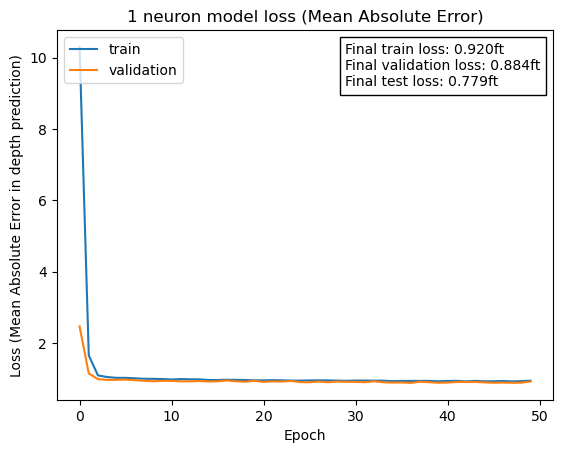

In [14]:
error_graph('1 neuron model', history, 'singleneuron/')

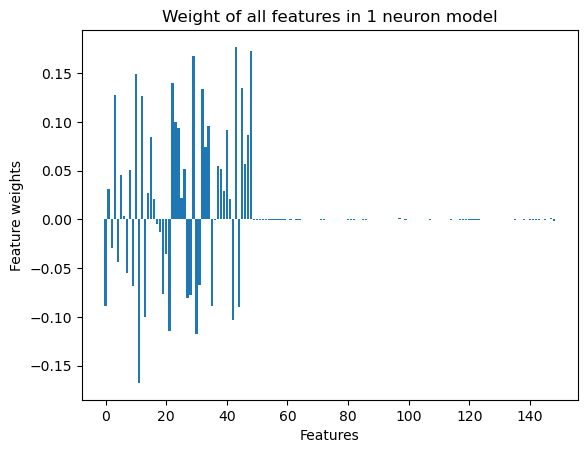

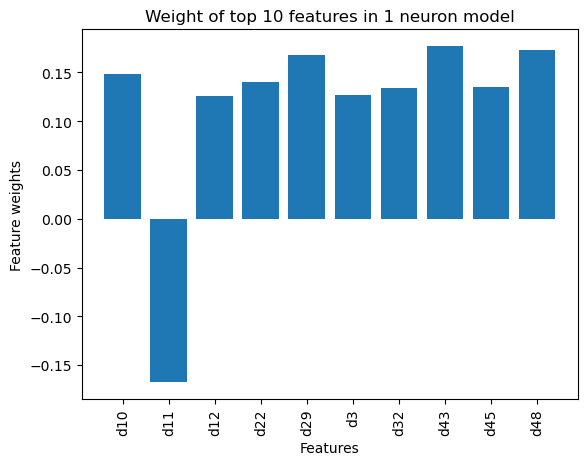

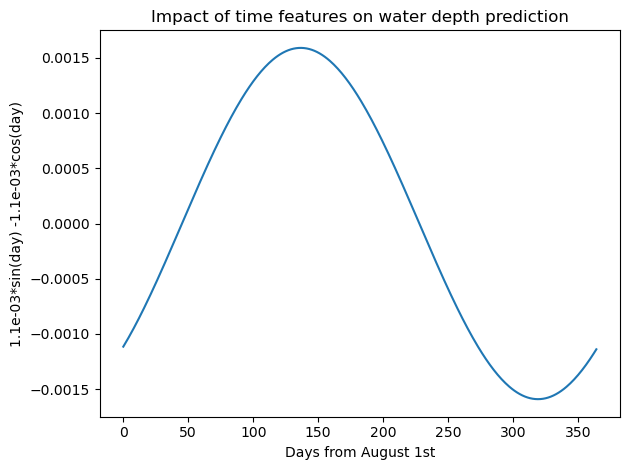

In [15]:
# based on https://www.tensorflow.org/tutorials/structured_data/time_series
model = load_model('singleneuron/', custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})

cols = list(X_val_df)[3:]
plt.bar(x=range(len(cols)),
        height=model.layers[0].kernel[:, 0].numpy())
plt.title('Weight of all features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.savefig('./presentation docs/coefficients_1neuron.png', dpi=200)
plt.show()

# top 10 features
top_num = 10
basic_coef_ord = np.argsort(np.absolute(model.layers[0].kernel[:, 0].numpy()))
new_cols = []
for idx in basic_coef_ord[-top_num:][::-1]:
    col_name = cols[idx]
    col_val = model.layers[0].kernel[:, 0].numpy()[idx]
    new_cols.append((col_name, col_val))
new_cols.sort(key=lambda x: x[0])
plt.bar(x=range(top_num),
        height=[b for a, b in new_cols])
axis = plt.gca()
axis.set_xticks(range(top_num))
_ = axis.set_xticklabels([a for a, b in new_cols], rotation=90)
plt.title(f'Weight of top {top_num} features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.savefig('./presentation docs/coefficients_1neuron_largest.png', dpi=200)
plt.show()

sin_coef, cos_coef = model.layers[0].kernel[:, 0].numpy()[-2:]
year_x = np.arange(365) * (2 * np.pi / 365.2425)
plt.plot(sin_coef*np.sin(year_x) + cos_coef*np.cos(year_x))
plt.xlabel('Days from August 1st')
plt.ylabel(f'{sin_coef:.1e}*sin(day) {cos_coef:.1e}*cos(day)')
plt.title('Impact of time features on water depth prediction')
plt.tight_layout()
plt.savefig('./presentation docs/time_coefficients_1neuron.png', dpi=200)
plt.show()

In [16]:
_ = gc.collect()

## Multi-layer perceptron

In [17]:
# powers of 2 are normal (64, 128, 256)
# low to high or high to low
# try adding dropout layer 0.1,0.2 (experiment)
# batch normalisation
# look into weight initialisation using he normal?
complex_model_2 = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(1)
])
complex_model_2.compile(loss=DepthMeanAbsoluteErrorLoss(),
              optimizer=tf.keras.optimizers.Adam(0.0007))
cp_multineuron = ModelCheckpoint('multineuron/', save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)

In [18]:
complex_history_2 = complex_model_2.fit(train_dataset, epochs=50, validation_data=validation_dataset, 
                                        shuffle=True, callbacks=[cp_multineuron, stop_early])

Epoch 1/50
215/215 [==============================] - 15s 63ms/step - loss: 2.2079 - val_loss: 1.2705
Epoch 2/50
215/215 [==============================] - 15s 62ms/step - loss: 1.1986 - val_loss: 1.4300
Epoch 3/50
215/215 [==============================] - 15s 66ms/step - loss: 1.1309 - val_loss: 1.2248
Epoch 4/50
215/215 [==============================] - 15s 65ms/step - loss: 1.1215 - val_loss: 1.2016
Epoch 5/50
215/215 [==============================] - 15s 64ms/step - loss: 1.0918 - val_loss: 0.9557
Epoch 6/50
215/215 [==============================] - 15s 64ms/step - loss: 1.0188 - val_loss: 1.2118
Epoch 7/50
215/215 [==============================] - 15s 66ms/step - loss: 1.0124 - val_loss: 1.0927
Epoch 8/50
215/215 [==============================] - 15s 65ms/step - loss: 0.9935 - val_loss: 0.9191
Epoch 9/50
215/215 [==============================] - 14s 62ms/step - loss: 0.9731 - val_loss: 0.9804
Epoch 10/50
215/215 [==============================] - 15s 64ms/step - loss: 1.027

In [ ]:
complex_model_2.summary()

4041/4041 [==============================] - 2s 485us/step - loss: 0.7132


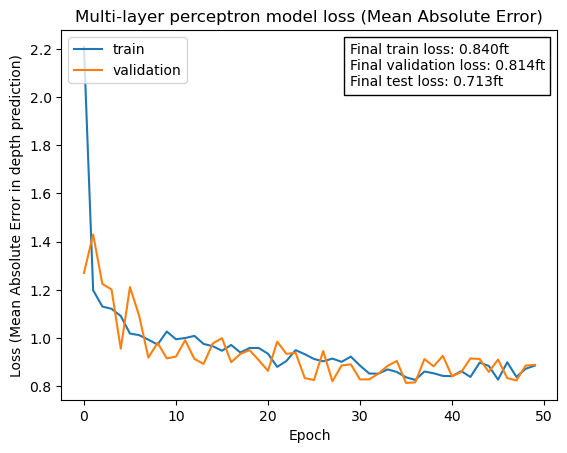

In [19]:
error_graph('Multi-layer perceptron model', complex_history_2, 'multineuron/')

## LSTM

In [36]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import Concatenate, Cropping1D
from tensorflow.keras.callbacks import ReduceLROnPlateau


n_steps = data_days
n_features =3
inputs = Input(shape=np.array(X_val_df.columns[3:]).shape)

# https://github.com/keras-team/keras/issues/890
everything, sin_cos = Lambda(lambda x: tf.split(x, num_or_size_splits=[data_days*3,2], axis=1))(inputs)
only_depth, _ = Lambda(lambda x: tf.split(x, num_or_size_splits=[data_days,data_days*2+2], axis=1))(inputs)

reshaped_everything = Lambda(lambda x: tf.experimental.numpy.reshape(x, (-1, n_steps, n_features), order='F'))(everything)
reshaped_only_depth = Lambda(lambda x: tf.experimental.numpy.reshape(x, (-1, n_steps, 1), order='F'))(only_depth)

output_2= LSTM(50, activation='relu', return_sequences=False)(reshaped_everything)
output_3 = Dense(32, activation='relu')(output_2)
predictions = Dense(1)(output_3)
complex_model_lstm = tf.keras.Model(inputs=inputs, outputs=predictions)

complex_model_lstm.compile(loss=DepthMeanAbsoluteErrorLoss(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003))

complex_model_lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 149)]             0         
                                                                 
 lambda_4 (Lambda)           [(None, 147),             0         
                              (None, 2)]                         
                                                                 
 lambda_6 (Lambda)           (None, 49, 3)             0         
                                                                 
 lstm (LSTM)                 (None, 50)                10800     
                                                                 
 dense_2 (Dense)             (None, 32)                1632      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                           

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=8, min_lr=0.0001)
cp_lstm = ModelCheckpoint('lstm/', save_best_only=True)
complex_history_lstm = complex_model_lstm.fit(train_dataset, epochs=50,
                                              validation_data=validation_dataset, shuffle=True, 
                                              callbacks=[reduce_lr, cp_lstm, stop_early])

Epoch 1/50
215/215 [==============================] - ETA: 0s - loss: 1.9100INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


215/215 [==============================] - 123s 568ms/step - loss: 1.9100 - val_loss: 1.6363 - lr: 0.0030
Epoch 2/50
215/215 [==============================] - ETA: 0s - loss: 1.0769INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


215/215 [==============================] - 123s 561ms/step - loss: 1.0769 - val_loss: 1.0973 - lr: 0.0030
Epoch 3/50
215/215 [==============================] - 119s 548ms/step - loss: 0.9917 - val_loss: 1.3210 - lr: 0.0030
Epoch 4/50
215/215 [==============================] - 122s 561ms/step - loss: 1.0153 - val_loss: 1.2529 - lr: 0.0030
Epoch 5/50
215/215 [==============================] - 119s 548ms/step - loss: 0.9490 - val_loss: 1.1220 - lr: 0.0030
Epoch 6/50
215/215 [==============================] - 121s 552ms/step - loss: 0.9758 - val_loss: 1.1041 - lr: 0.0030
Epoch 7/50
215/215 [==============================] - 119s 551ms/step - loss: 0.9469 - val_loss: 1.1778 - lr: 0.0030
Epoch 8/50
215/215 [==============================] - ETA: 0s - loss: 0.9799INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


215/215 [==============================] - 121s 555ms/step - loss: 0.9799 - val_loss: 0.9959 - lr: 0.0030
Epoch 9/50
215/215 [==============================] - 119s 547ms/step - loss: 0.9275 - val_loss: 1.3216 - lr: 0.0030
Epoch 10/50
215/215 [==============================] - ETA: 0s - loss: 0.9471INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


215/215 [==============================] - 120s 555ms/step - loss: 0.9471 - val_loss: 0.9264 - lr: 0.0030
Epoch 11/50
215/215 [==============================] - 120s 551ms/step - loss: 0.9276 - val_loss: 1.1089 - lr: 0.0030
Epoch 12/50
215/215 [==============================] - ETA: 0s - loss: 0.8690INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


215/215 [==============================] - 121s 556ms/step - loss: 0.8690 - val_loss: 0.8833 - lr: 0.0030
Epoch 13/50
215/215 [==============================] - 121s 554ms/step - loss: 0.8921 - val_loss: 1.1969 - lr: 0.0030
Epoch 14/50
215/215 [==============================] - 119s 550ms/step - loss: 1.0255 - val_loss: 1.0111 - lr: 0.0030
Epoch 15/50
215/215 [==============================] - 119s 550ms/step - loss: 0.9338 - val_loss: 0.9959 - lr: 0.0030
Epoch 16/50
215/215 [==============================] - 119s 548ms/step - loss: 0.9097 - val_loss: 0.8921 - lr: 0.0030
Epoch 17/50
215/215 [==============================] - ETA: 0s - loss: 0.9097INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


215/215 [==============================] - 119s 549ms/step - loss: 0.9097 - val_loss: 0.8662 - lr: 0.0030
Epoch 18/50
215/215 [==============================] - 123s 564ms/step - loss: 0.8753 - val_loss: 0.9101 - lr: 0.0030
Epoch 19/50
215/215 [==============================] - 117s 540ms/step - loss: 0.9172 - val_loss: 1.1409 - lr: 0.0030
Epoch 20/50
215/215 [==============================] - 122s 563ms/step - loss: 0.9001 - val_loss: 1.1173 - lr: 0.0030
Epoch 21/50
215/215 [==============================] - 120s 550ms/step - loss: 0.8688 - val_loss: 1.3163 - lr: 0.0030
Epoch 22/50
215/215 [==============================] - 120s 553ms/step - loss: 0.8992 - val_loss: 1.1157 - lr: 0.0030
Epoch 23/50
215/215 [==============================] - 120s 553ms/step - loss: 0.9046 - val_loss: 0.9684 - lr: 0.0030
Epoch 24/50
215/215 [==============================] - ETA: 0s - loss: 0.8551INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


215/215 [==============================] - 121s 558ms/step - loss: 0.8551 - val_loss: 0.8403 - lr: 0.0030
Epoch 25/50
215/215 [==============================] - 120s 550ms/step - loss: 0.8870 - val_loss: 1.0102 - lr: 0.0030
Epoch 26/50
215/215 [==============================] - 119s 551ms/step - loss: 0.8504 - val_loss: 0.9062 - lr: 0.0030
Epoch 27/50
215/215 [==============================] - ETA: 0s - loss: 0.8618INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


215/215 [==============================] - 121s 556ms/step - loss: 0.8618 - val_loss: 0.8261 - lr: 0.0030
Epoch 28/50
215/215 [==============================] - ETA: 0s - loss: 0.8586INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


215/215 [==============================] - 120s 553ms/step - loss: 0.8586 - val_loss: 0.8154 - lr: 0.0030
Epoch 29/50
215/215 [==============================] - 118s 542ms/step - loss: 0.8507 - val_loss: 0.8316 - lr: 0.0030
Epoch 30/50
204/215 [===========================>..] - ETA: 4s - loss: 0.8413

In [ ]:
error_graph('LSTM model', complex_history_lstm, 'lstm/')

## Making small dataset without outliers

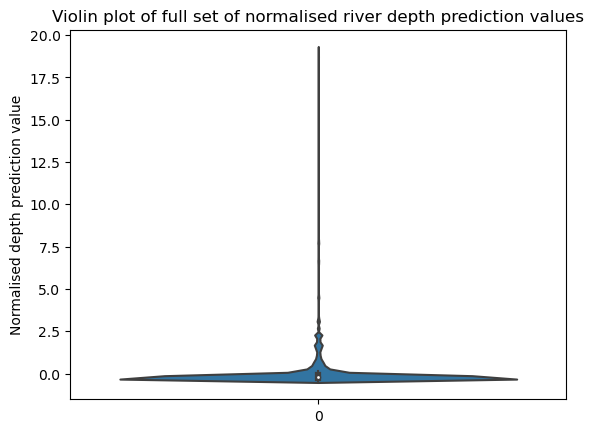

In [7]:
# X_train_df_small = X_train_df[np.absolute(X_train_df['y']/ np.mean())<2.5]
import seaborn as sns
sns.violinplot(X_train_df['y'])
plt.ylabel('Normalised depth prediction value')
plt.title('Violin plot of full set of normalised river depth prediction values')
plt.savefig('./presentation docs/violin_plot_prediction_vals_full.png', dpi=200)
plt.show()

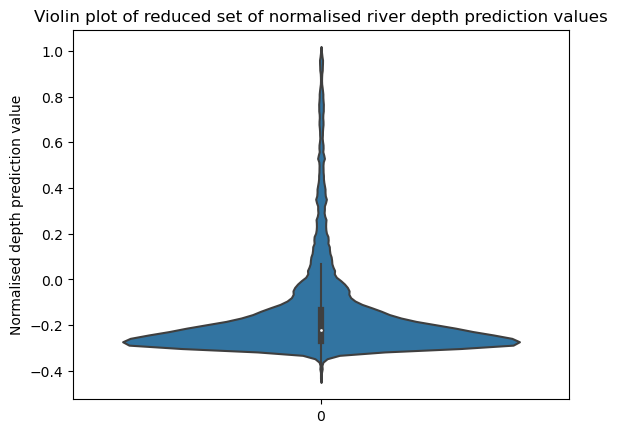

Rows reduced from 4,281,664 to 4,071,557 - a decrease of 4.907134%


In [8]:
# np.abs(y_change)<1
X_train_df_small = X_train_df[np.abs(X_train_df['y'])<1]
sns.violinplot(X_train_df_small['y'])
plt.ylabel('Normalised depth prediction value')
plt.title('Violin plot of reduced set of normalised river depth prediction values')
plt.savefig('./presentation docs/violin_plot_prediction_vals_reduced.png', dpi=200)
plt.show()

origlength = len(X_train_df)
newlength = len(X_train_df_small)
print(f'Rows reduced from {origlength:,} to {newlength:,} - a decrease of {1-newlength/origlength:%}')

In [11]:
train_dataset_small = tf.data.Dataset.from_tensor_slices((X_train_df_small.iloc[:, 3:], X_train_df_small.iloc[:, [0]])).cache()
train_dataset_small = train_dataset_small.shuffle(60000).batch(20000).prefetch(tf.data.AUTOTUNE)

## LSTM on small dataset

In [ ]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import Concatenate, Cropping1D
from tensorflow.keras.callbacks import ReduceLROnPlateau

n_steps = data_days
n_features =3
inputs = Input(shape=np.array(X_val_df.columns[3:]).shape)

# https://github.com/keras-team/keras/issues/890
everything, sin_cos = Lambda(lambda x: tf.split(x, num_or_size_splits=[data_days*3,2], axis=1))(inputs)
only_depth, _ = Lambda(lambda x: tf.split(x, num_or_size_splits=[data_days,data_days*2+2], axis=1))(inputs)

reshaped_everything = Lambda(lambda x: tf.experimental.numpy.reshape(x, (-1, n_steps, n_features), order='F'))(everything)
reshaped_only_depth = Lambda(lambda x: tf.experimental.numpy.reshape(x, (-1, n_steps, 1), order='F'))(only_depth)

output_2= LSTM(50, activation='relu', return_sequences=False)(reshaped_everything)
output_3 = Dense(32, activation='relu')(output_2)
predictions = Dense(1)(output_3)
complex_model_lstm_small = tf.keras.Model(inputs=inputs, outputs=predictions)

complex_model_lstm_small.compile(loss=DepthMeanAbsoluteErrorLoss(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003))

complex_model_lstm_small.summary()

In [ ]:
from IPython.display import clear_output
# https://stackoverflow.com/questions/71277832/overwrite-plot-every-epoch

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        predictions = complex_model_lstm_small.predict(x=X_train_df.iloc[pos:pos+points, 3:]).reshape(-1)
        true_vals = X_train_df.iloc[pos:pos+points, 0]
        plt.scatter(range(points), predictions, label="Predicted")
        plt.scatter(range(points), true_vals, label="True")
        plt.legend()
        plt.title('Predictions of LSTM model vs true')
        plt.xlabel('Day')
        plt.show()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
cp_lstm_small = ModelCheckpoint('lstm_small/', save_best_only=True)
complex_history_lstm_small = complex_model_lstm_small.fit(train_dataset_small, epochs=50,
                                              validation_data=validation_dataset, shuffle=True, 
                                              callbacks=[cp_lstm_small, reduce_lr, stop_early])

In [ ]:
error_graph('LSTM model trained on small dataset', complex_history_lstm_small,'lstm_small/')

## CNN

In [85]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import Concatenate, Cropping1D, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

n_steps = data_days
n_features =3
conv_days = 4
inputs = Input(shape=np.array(X_val_df.columns[3:]).shape)

# https://github.com/keras-team/keras/issues/890
# https://machinelearningmastery.com/using-cnn-for-financial-time-series-prediction/
# https://towardsdatascience.com/time-series-forecasting-with-2d-convolutions-4f1a0f33dff6
everything, sin_cos = Lambda(lambda x: tf.split(x, num_or_size_splits=[data_days*3,2], axis=1))(inputs)
only_depth, _ = Lambda(lambda x: tf.split(x, num_or_size_splits=[data_days,data_days*2+2], axis=1))(inputs)

reshaped_everything = Lambda(lambda x: tf.experimental.numpy.reshape(x, (-1, n_steps, n_features, 1), order='F'))(everything)
reshaped_only_depth = Lambda(lambda x: tf.experimental.numpy.reshape(x, (-1, n_steps, 1, 1), order='F'))(only_depth)

output_2 = Conv2D(10, kernel_size=(conv_days, 2), padding="same")(reshaped_everything)
pooling = MaxPool2D(pool_size=(3,1))(output_2)
output_flat = Flatten()(pooling)
output_3 = Dense(32)(output_flat)
predictions = Dense(1)(output_3)
complex_model_conv = tf.keras.Model(inputs=inputs, outputs=predictions)

complex_model_conv.compile(loss=DepthMeanAbsoluteErrorLoss(),
              optimizer=tf.keras.optimizers.Adam(0.0003))

complex_model_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 149)]             0         
                                                                 
 lambda (Lambda)             [(None, 147),             0         
                              (None, 2)]                         
                                                                 
 lambda_2 (Lambda)           (None, 49, 3, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 49, 3, 10)         90        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 3, 10)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 480)               0     

In [86]:
cp_conv = ModelCheckpoint('conv/', save_best_only=True)
complex_history_conv = complex_model_conv.fit(train_dataset, epochs=50,
                                              validation_data=validation_dataset, shuffle=True, 
                                                          callbacks=[cp_conv, stop_early])

Epoch 1/50
213/215 [============================>.] - ETA: 0s - loss: 3.7385INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 33s 151ms/step - loss: 3.7277 - val_loss: 1.7720
Epoch 2/50
214/215 [============================>.] - ETA: 0s - loss: 1.4631INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 91ms/step - loss: 1.4630 - val_loss: 1.2862
Epoch 3/50
214/215 [============================>.] - ETA: 0s - loss: 1.2371INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 90ms/step - loss: 1.2370 - val_loss: 1.1588
Epoch 4/50
214/215 [============================>.] - ETA: 0s - loss: 1.1289INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 90ms/step - loss: 1.1288 - val_loss: 1.1503
Epoch 5/50
215/215 [==============================] - ETA: 0s - loss: 1.0903INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 91ms/step - loss: 1.0903 - val_loss: 1.0153
Epoch 6/50
215/215 [==============================] - 21s 90ms/step - loss: 1.0722 - val_loss: 1.1044
Epoch 7/50
214/215 [============================>.] - ETA: 0s - loss: 1.0089INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 91ms/step - loss: 1.0089 - val_loss: 0.9535
Epoch 8/50
215/215 [==============================] - 20s 88ms/step - loss: 1.0275 - val_loss: 1.0535
Epoch 9/50
215/215 [==============================] - 21s 91ms/step - loss: 1.0361 - val_loss: 0.9809
Epoch 10/50
213/215 [============================>.] - ETA: 0s - loss: 0.9576INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 92ms/step - loss: 0.9571 - val_loss: 0.9111
Epoch 11/50
215/215 [==============================] - 21s 90ms/step - loss: 0.9586 - val_loss: 0.9136
Epoch 12/50
215/215 [==============================] - 20s 88ms/step - loss: 1.0024 - val_loss: 0.9595
Epoch 13/50
215/215 [==============================] - 21s 92ms/step - loss: 0.9460 - val_loss: 0.9628
Epoch 14/50
215/215 [==============================] - 21s 90ms/step - loss: 0.9598 - val_loss: 0.9492
Epoch 15/50
215/215 [==============================] - 21s 88ms/step - loss: 0.9288 - val_loss: 0.9639
Epoch 16/50
214/215 [============================>.] - ETA: 0s - loss: 0.9512INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 91ms/step - loss: 0.9512 - val_loss: 0.8822
Epoch 17/50
215/215 [==============================] - 21s 93ms/step - loss: 0.9579 - val_loss: 0.9274
Epoch 18/50
215/215 [==============================] - 21s 90ms/step - loss: 0.9532 - val_loss: 0.9259
Epoch 19/50
215/215 [==============================] - 24s 106ms/step - loss: 0.9267 - val_loss: 0.8834
Epoch 20/50
213/215 [============================>.] - ETA: 0s - loss: 0.9507INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 91ms/step - loss: 0.9504 - val_loss: 0.8748
Epoch 21/50
215/215 [==============================] - 21s 91ms/step - loss: 0.9181 - val_loss: 0.8957
Epoch 22/50
215/215 [==============================] - ETA: 0s - loss: 0.9344INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 92ms/step - loss: 0.9344 - val_loss: 0.8541
Epoch 23/50
215/215 [==============================] - 21s 89ms/step - loss: 0.9034 - val_loss: 0.9125
Epoch 24/50
215/215 [==============================] - 21s 90ms/step - loss: 0.9164 - val_loss: 0.9267
Epoch 25/50
214/215 [============================>.] - ETA: 0s - loss: 0.9223INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 21s 90ms/step - loss: 0.9223 - val_loss: 0.8498
Epoch 26/50
215/215 [==============================] - 20s 87ms/step - loss: 0.9062 - val_loss: 0.8511
Epoch 27/50
215/215 [==============================] - 19s 83ms/step - loss: 0.9308 - val_loss: 0.8900
Epoch 28/50
215/215 [==============================] - 21s 91ms/step - loss: 0.9368 - val_loss: 0.9274
Epoch 29/50
215/215 [==============================] - 19s 84ms/step - loss: 0.9061 - val_loss: 0.8656
Epoch 30/50
215/215 [==============================] - 21s 94ms/step - loss: 0.9182 - val_loss: 0.9026
Epoch 31/50
215/215 [==============================] - 21s 93ms/step - loss: 0.8952 - val_loss: 0.8793
Epoch 32/50
215/215 [==============================] - ETA: 0s - loss: 0.9167INFO:tensorflow:Assets written to: conv/assets


INFO:tensorflow:Assets written to: conv/assets


215/215 [==============================] - 23s 101ms/step - loss: 0.9167 - val_loss: 0.8315
Epoch 33/50
215/215 [==============================] - 22s 95ms/step - loss: 0.8861 - val_loss: 0.8547
Epoch 34/50
215/215 [==============================] - 22s 95ms/step - loss: 0.8974 - val_loss: 0.8546
Epoch 35/50
215/215 [==============================] - 20s 88ms/step - loss: 0.9131 - val_loss: 0.8862
Epoch 36/50
215/215 [==============================] - 22s 98ms/step - loss: 0.8914 - val_loss: 0.8362
Epoch 37/50
215/215 [==============================] - 23s 102ms/step - loss: 0.8735 - val_loss: 0.8741
Epoch 38/50
215/215 [==============================] - 20s 88ms/step - loss: 0.8746 - val_loss: 0.8839
Epoch 39/50
215/215 [==============================] - 20s 88ms/step - loss: 0.9081 - val_loss: 0.8375
Epoch 40/50
215/215 [==============================] - 20s 88ms/step - loss: 0.8933 - val_loss: 0.8847
Epoch 41/50
215/215 [==============================] - 23s 101ms/step - loss: 0.911

4041/4041 [==============================] - 3s 822us/step - loss: 0.7408


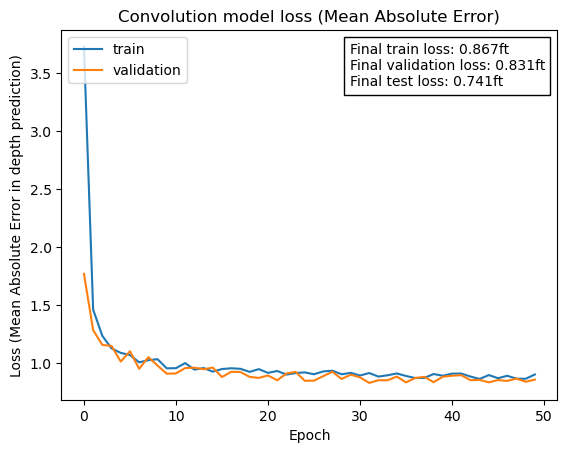

In [87]:
error_graph('Convolution model', complex_history_conv, 'conv/')

In [ ]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import Concatenate, Cropping1D, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

n_steps = data_days
n_features =3
conv_days = 4
inputs = Input(shape=np.array(X_val_df.columns[3:]).shape)

# https://github.com/keras-team/keras/issues/890
# https://machinelearningmastery.com/using-cnn-for-financial-time-series-prediction/
# https://towardsdatascience.com/time-series-forecasting-with-2d-convolutions-4f1a0f33dff6
everything, sin_cos = Lambda(lambda x: tf.split(x, num_or_size_splits=[data_days*3,2], axis=1))(inputs)
only_depth, _ = Lambda(lambda x: tf.split(x, num_or_size_splits=[data_days,data_days*2+2], axis=1))(inputs)

reshaped_everything = Lambda(lambda x: tf.experimental.numpy.reshape(x, (-1, n_steps, n_features, 1), order='F'))(everything)
reshaped_only_depth = Lambda(lambda x: tf.experimental.numpy.reshape(x, (-1, n_steps, 1, 1), order='F'))(only_depth)

output_2 = Conv2D(10, kernel_size=(conv_days, 2), padding="same")(reshaped_everything)
pooling = MaxPool2D(pool_size=(3,1))(output_2)
output_flat = Flatten()(pooling)
output_3 = Dense(32)(output_flat)
predictions = Dense(1)(output_3)
complex_model_conv_small = tf.keras.Model(inputs=inputs, outputs=predictions)

complex_model_conv_small.compile(loss=DepthMeanAbsoluteErrorLoss(),
              optimizer=tf.keras.optimizers.Adam(0.0003))

complex_model_conv_small.summary()

In [ ]:
cp_conv_small = ModelCheckpoint('conv_small/', save_best_only=True)
complex_history_conv_small = complex_model_conv_small.fit(train_dataset_small, epochs=50,
                                              validation_data=validation_dataset, shuffle=True, 
                                                          callbacks=[cp_conv_small, stop_early])

In [ ]:
error_graph('Convolution model trained on small dataset', complex_history_conv_small, 'conv_small/')

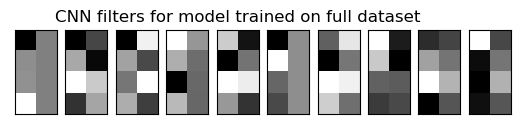

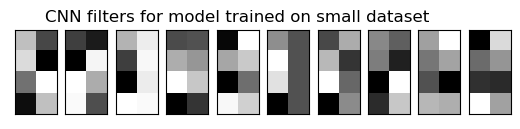

In [88]:
n_steps = data_days
n_features =3
conv_days = 4

complex_model_conv = load_model('conv/', custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})
# https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
filters, biases = complex_model_conv.layers[3].get_weights()
total_filters = filters.shape[3]

for i in range(total_filters):
    if i==5: plt.title('CNN filters for model trained on full dataset')
    ax = plt.subplot(1, total_filters, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    f = filters[:, :, :, i]
    channel = 0 # only 1 channel
    plt.imshow(f[:, :, channel], cmap='gray')
plt.savefig('./presentation docs/cnn_filters.png', dpi=200)
plt.show()

complex_model_conv_small = load_model('conv_small/', custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})
filters, biases = complex_model_conv_small.layers[3].get_weights()
total_filters = filters.shape[3]

for i in range(total_filters):
    if i==5: plt.title('CNN filters for model trained on small dataset')
    ax = plt.subplot(1, total_filters, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    f = filters[:, :, :, i]
    channel = 0 # only 1 channel
    plt.imshow(f[:, :, channel], cmap='gray')
plt.savefig('./presentation docs/cnn_filters_small.png', dpi=200)
plt.show()

## Predict on test set using all models

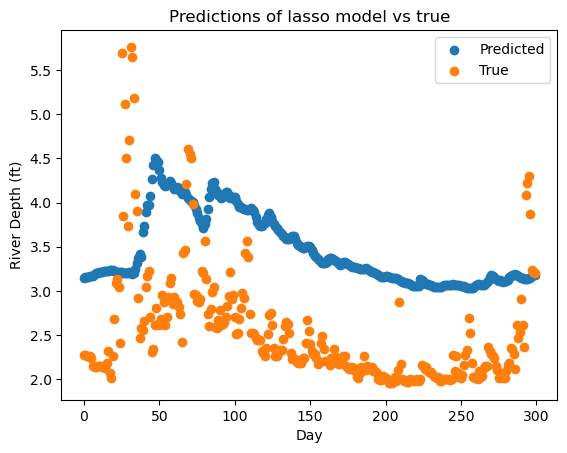

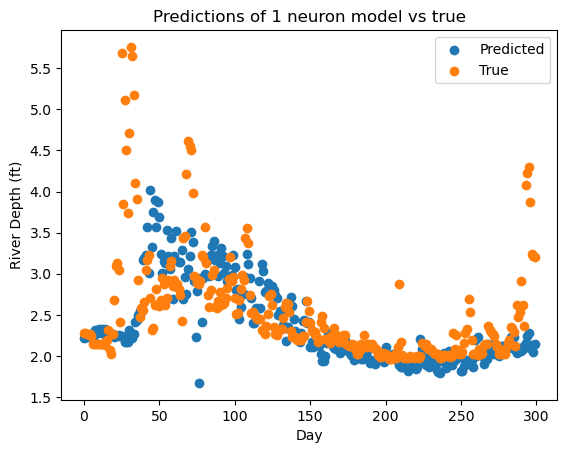

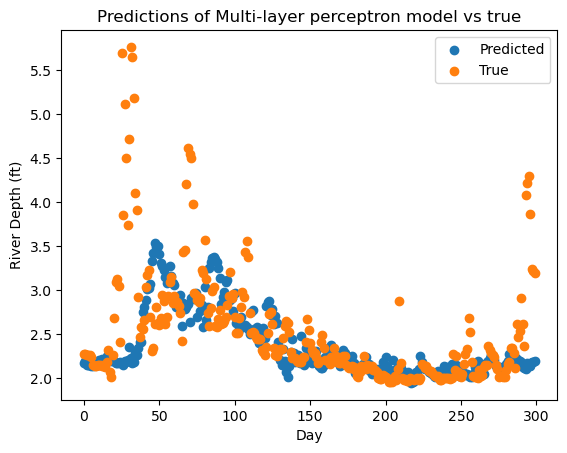

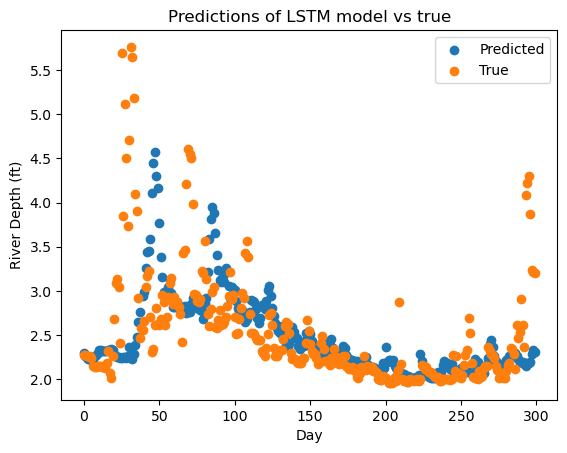

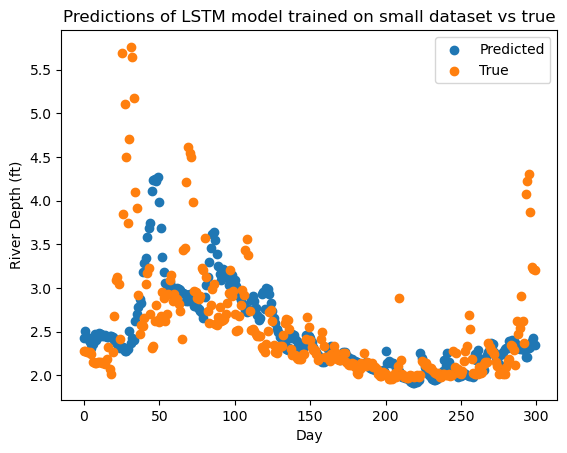

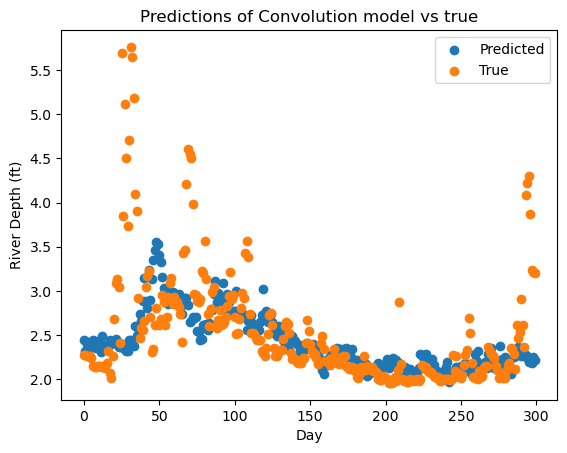

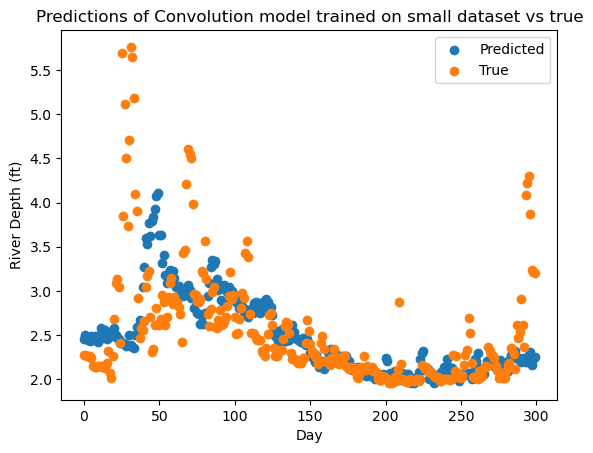

In [8]:
from tensorflow.keras.models import load_model

n_steps = data_days
n_features =3
conv_days = 4
points = 300
pos = 130


def graph_model(model_name, trained_model):
    predictions = trained_model.predict(x=X_test_df.iloc[pos:pos+points, 3:], verbose=0).reshape(-1)
    true_vals = X_test_df.iloc[pos:pos+points, 0]
    plt.scatter(range(points), undo_depth(predictions), label="Predicted")
    plt.scatter(range(points), undo_depth(true_vals), label="True")
    plt.legend()
    plt.title(f'Predictions of {model_name} vs true')
    plt.ylabel('River Depth (ft)')
    plt.xlabel('Day')
    plt.savefig(f'./presentation docs/{model_name}_test_pred.png', dpi=200)
    plt.show()

predictions = lasso.predict(X_test_df.iloc[pos:pos+points, 3:]).reshape(-1)
true_vals = X_test_df.iloc[pos:pos+points, 0]
plt.scatter(range(points), undo_depth(predictions), label="Predicted")
plt.scatter(range(points), undo_depth(true_vals), label="True")
plt.legend()
plt.title(f'Predictions of lasso model vs true')
plt.ylabel('River Depth (ft)')
plt.xlabel('Day')
plt.savefig('./presentation docs/lasso_test_pred.png', dpi=200)
plt.show()

model = load_model('singleneuron/', custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})
graph_model('1 neuron model', model)

complex_model_2 = load_model('multineuron/', custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})
graph_model('Multi-layer perceptron model', complex_model_2)

complex_model_lstm = load_model('lstm/', custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})
graph_model('LSTM model', complex_model_lstm)

complex_model_lstm_small =  load_model('lstm_small/', custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})
graph_model('LSTM model trained on small dataset', complex_model_lstm_small)

complex_model_conv =  load_model('conv/', custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})
graph_model('Convolution model', complex_model_conv)

complex_model_conv_small =  load_model('conv_small/', custom_objects={"DepthMeanAbsoluteErrorLoss": DepthMeanAbsoluteErrorLoss})
graph_model('Convolution model trained on small dataset', complex_model_conv_small)

In [98]:
true_vals = undo_depth(X_test_df.iloc[:, 0].to_numpy().reshape(-1))

naive_error = undo_depth(X_test_df.iloc[:, 3+48].to_numpy().reshape(-1))
lasso_error = true_vals - undo_depth(lasso.predict(X_test_df.iloc[:, 3:]).reshape(-1))
model_error = true_vals - undo_depth(model.predict(x=X_test_df.iloc[:, 3:], verbose=0).reshape(-1))
complex_model_2_error = true_vals - undo_depth(complex_model_2.predict(x=X_test_df.iloc[:, 3:], verbose=0).reshape(-1))
complex_model_lstm_error = true_vals - undo_depth(complex_model_lstm.predict(x=X_test_df.iloc[:, 3:], verbose=0).reshape(-1))
complex_model_lstm_small_error = true_vals - undo_depth(complex_model_lstm_small.predict(x=X_test_df.iloc[:, 3:], verbose=0).reshape(-1))
complex_model_conv_error = true_vals - undo_depth(complex_model_conv.predict(x=X_test_df.iloc[:, 3:], verbose=0).reshape(-1))
complex_model_conv_small_error = true_vals - undo_depth(complex_model_conv_small.predict(x=X_test_df.iloc[:, 3:], verbose=0).reshape(-1))

In [99]:
conv_to_cm = 30.48
naive_error = naive_error * conv_to_cm
lasso_error = lasso_error * conv_to_cm
model_error = model_error * conv_to_cm
complex_model_2_error = complex_model_2_error * conv_to_cm
complex_model_lstm_error = complex_model_lstm_error * conv_to_cm
complex_model_lstm_small_error = complex_model_lstm_small_error * conv_to_cm
complex_model_conv_error = complex_model_conv_error * conv_to_cm
complex_model_conv_small_error = complex_model_conv_small_error * conv_to_cm

In [100]:
max_err = np.max([lasso_error, model_error, complex_model_2_error, complex_model_lstm_error, complex_model_lstm_small_error, complex_model_conv_error, complex_model_conv_small_error])
min_err = np.min([lasso_error, model_error, complex_model_2_error, complex_model_lstm_error, complex_model_lstm_small_error, complex_model_conv_error, complex_model_conv_small_error])

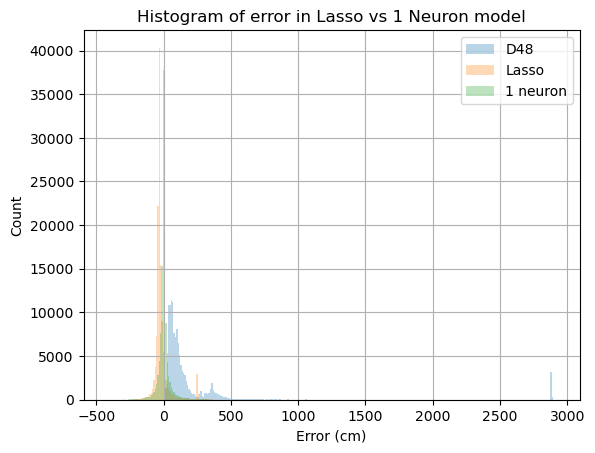

In [101]:
err_alpha = 0.3
max_err = np.max([naive_error, lasso_error, model_error])
min_err = np.min([naive_error, lasso_error, model_error])
size = 10

plt.hist(naive_error,bins=np.arange(min_err, max_err+size,size), label='D48', alpha = err_alpha)
plt.hist(lasso_error,bins=np.arange(min_err, max_err+size,size), label='Lasso', alpha = err_alpha)
plt.hist(model_error,bins=np.arange(min_err, max_err+size,size), label='1 neuron', alpha = err_alpha)
plt.grid()
plt.legend()

plt.xlabel('Error (cm)')
plt.ylabel('Count')
plt.title('Histogram of error in Lasso vs 1 Neuron model')
plt.savefig('./presentation docs/lasso_vs_1_neuron_hist.png', dpi=200)
plt.show()

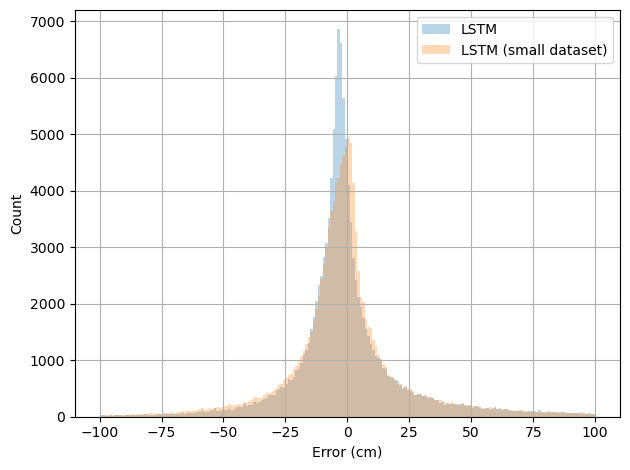

In [102]:
size=1
err_bins = np.arange(-100, 100+size,size)
err_alpha = 0.3

# plt.hist(complex_model_2_error,bins=err_bins, label='Multi-layer perceptron model', alpha=err_alpha)
plt.hist(complex_model_lstm_error,bins=err_bins, label='LSTM', alpha=err_alpha)
plt.hist(complex_model_lstm_small_error,bins=err_bins, label='LSTM (small dataset)', alpha=err_alpha)
# plt.hist(complex_model_conv_error,bins=err_bins, label='Convolution model', alpha=err_alpha)
# plt.hist(complex_model_conv_small_error,bins=err_bins, label='Convolution model trained on small dataset', alpha=err_alpha)
plt.legend()
plt.grid()
plt.xlabel('Error (cm)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('./presentation docs/big_v_small_lstm.png', dpi=200)
plt.show()

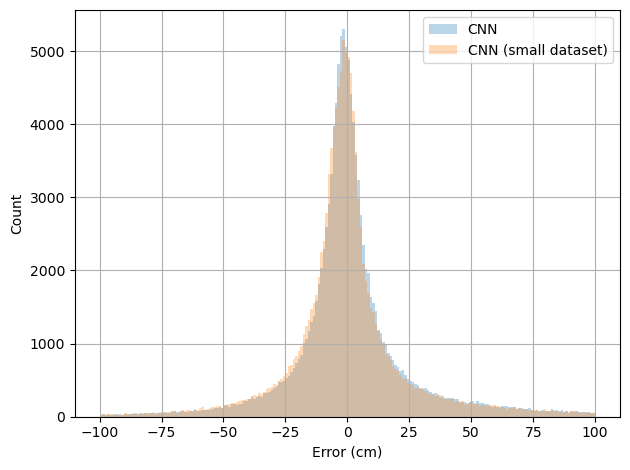

In [103]:
plt.hist(complex_model_conv_error,bins=err_bins, label='CNN', alpha=err_alpha)
plt.hist(complex_model_conv_small_error,bins=err_bins, label='CNN (small dataset)', alpha=err_alpha)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.xlabel('Error (cm)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('./presentation docs/big_v_small_conv.png', dpi=200)
plt.show()

Probability within 25cm for:
Naive:                                      1.3%
Lasso:                                      25.5%
1 neuron model:                             75.3%
Multi-layer perceptron model:               78.3%
LSTM model:                                 79.0%
LSTM model trained on small dataset:        76.6%
Convolution model:                          77.5%
Convolution model trained on small dataset: 77.6%


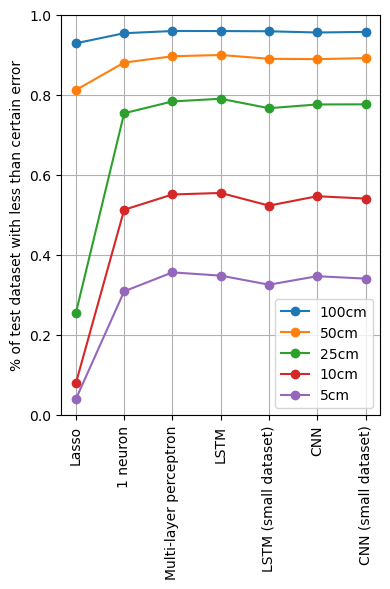

In [115]:
names = ['Lasso','1 neuron', 'Multi-layer perceptron', 'LSTM', 'LSTM (small dataset)', 'CNN', 'CNN (small dataset)']
plt.figure(figsize=(4, 6))
for within in [5,10,25,50,100][::-1]:
    p_right_naive = sum(np.abs(naive_error) < within) / len(naive_error)
    p_right_lasso = sum(np.abs(lasso_error) < within) / len(lasso_error)
    p_right_model = sum(np.abs(model_error) < within) / len(model_error)
    p_right_model_2 = sum(np.abs(complex_model_2_error) < within) / len(complex_model_2_error)
    p_right_complex_model_lstm = sum(np.abs(complex_model_lstm_error) < within) / len(complex_model_lstm_error)
    p_right_complex_model_lstm_small = sum(np.abs(complex_model_lstm_small_error) < within) / len(complex_model_lstm_small_error)
    p_right_complex_model_conv = sum(np.abs(complex_model_conv_error) < within) / len(complex_model_conv_error)
    p_right_complex_model_conv_small = sum(np.abs(complex_model_conv_small_error) < within) / len(complex_model_conv_small_error)

    if within == 25:
        print(f'Probability within {within}cm for:')
        print(f'Naive:                                      {p_right_naive:.1%}')
        print(f'Lasso:                                      {p_right_lasso:.1%}')
        print(f'1 neuron model:                             {p_right_model:.1%}')
        print(f'Multi-layer perceptron model:               {p_right_model_2:.1%}')
        print(f'LSTM model:                                 {p_right_complex_model_lstm:.1%}')
        print(f'LSTM model trained on small dataset:        {p_right_complex_model_lstm_small:.1%}')
        print(f'Convolution model:                          {p_right_complex_model_conv:.1%}')
        print(f'Convolution model trained on small dataset: {p_right_complex_model_conv_small:.1%}')

    plt.plot([p_right_lasso, p_right_model, p_right_model_2, p_right_complex_model_lstm, p_right_complex_model_lstm_small, p_right_complex_model_conv, p_right_complex_model_conv_small],'-o',
                label=f'{within}cm')
plt.ylim([0,1])
plt.xticks(range(len(names)), names, rotation = 90)
plt.ylabel(f'% of test dataset with less than certain error')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./presentation docs/%testsetwithin_errors.png', dpi=200)
plt.show()

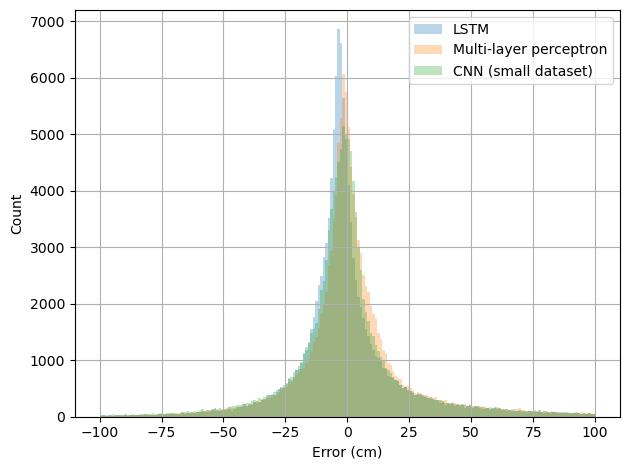

In [113]:
plt.hist(complex_model_lstm_error,bins=err_bins, label='LSTM', alpha=err_alpha)
plt.hist(complex_model_2_error,bins=err_bins, label='Multi-layer perceptron', alpha=err_alpha)
plt.hist(complex_model_conv_small_error,bins=err_bins, label='CNN (small dataset)', alpha=err_alpha)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.xlabel('Error (cm)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('./presentation docs/error_best_models.png', dpi=200)
plt.show()

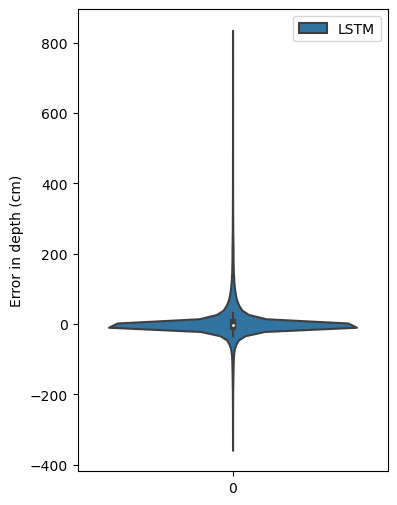

In [148]:
plt.figure(figsize=(4, 6))
sns.violinplot(complex_model_lstm_error)
plt.ylabel('Error in depth (cm)')
plt.legend(['LSTM'])
plt.savefig('./presentation docs/error_lstm_violin.png', dpi=200)
plt.show()

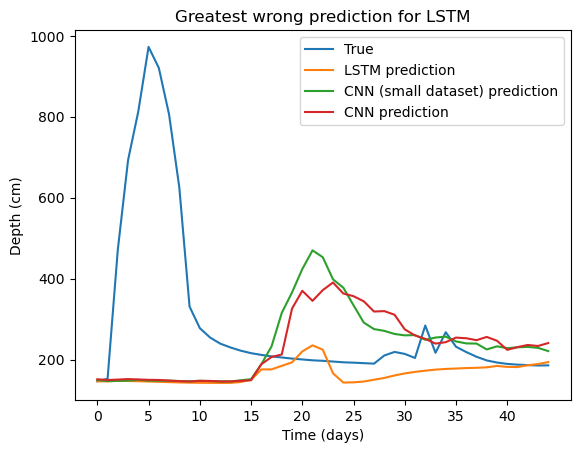

In [151]:
max_error_idx = np.argmax(complex_model_lstm_small_error)
day_start = max_error_idx-5
day_end = max_error_idx+40
plt.plot(conv_to_cm*undo_depth(X_test_df.iloc[day_start:day_end, 0]).to_numpy().reshape(-1), label="True")
plt.plot(conv_to_cm*undo_depth((complex_model_lstm.predict(x=X_test_df.iloc[day_start:day_end, 3:], verbose=0).reshape(-1))), label="LSTM prediction")
plt.plot(conv_to_cm*undo_depth((complex_model_conv_small.predict(x=X_test_df.iloc[day_start:day_end, 3:], verbose=0).reshape(-1))), label = "CNN (small dataset) prediction")
plt.plot(conv_to_cm*undo_depth((complex_model_conv.predict(x=X_test_df.iloc[day_start:day_end, 3:], verbose=0).reshape(-1))), label = "CNN prediction")
plt.legend()
plt.title('Greatest wrong prediction for LSTM')
plt.ylabel('Depth (cm)')
plt.xlabel('Time (days)')
plt.xticks(range(0,45,5))
plt.savefig('./presentation docs/worst_errors_in_depth_prediction.png', dpi=200)
plt.show()

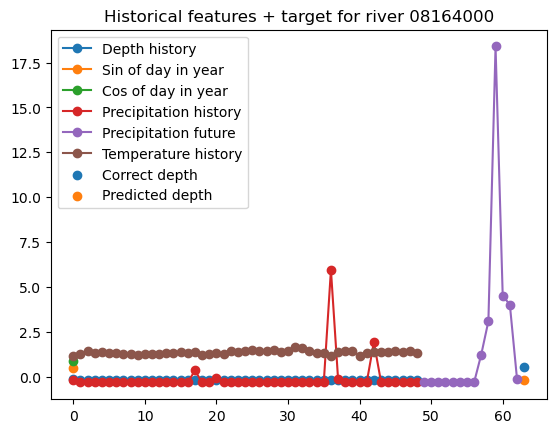

In [152]:
rowIdx = max_error_idx
predicted_val = complex_model_conv.predict(x=X_test_df.iloc[[rowIdx], 3:], verbose=0).reshape(-1)
y_point = X_test_df.iloc[rowIdx, :]['y']
all_ds = [f'd{idx}' for idx in range(data_days)]
all_ps = [f'p{idx}' for idx in range(data_days)]
all_ts = [f't{idx}' for idx in range(data_days)]
d_points = X_test_df.iloc[rowIdx, :][all_ds].to_list()
p_points = X_test_df.iloc[rowIdx, :][all_ps].to_list()
t_points = X_test_df.iloc[rowIdx, :][all_ts].to_list()
sin = X_test_df.iloc[rowIdx, :]['year_sin']
cos = X_test_df.iloc[rowIdx, :]['year_cos']
plt.plot(range(data_days), d_points, '-o', label='Depth history')
plt.plot(0,sin, '-o', label='Sin of day in year')
plt.plot(0,cos, '-o', label='Cos of day in year')
plt.plot(range(data_days), p_points, '-o', label='Precipitation history')
future_rain = X_test_df.iloc[rowIdx+future_days, :][all_ps[-future_days:]].to_list()
plt.plot(range(data_days, data_days+future_days), future_rain, '-o', label='Precipitation future')
plt.plot(range(data_days), t_points, '-o', label='Temperature history')
plt.scatter(data_days + future_days, y_point, label='Correct depth')
plt.scatter(data_days + future_days, predicted_val, label='Predicted depth')
plt.legend()
riv_name = X_test_df.iloc[rowIdx, :]['river']
plt.title(f'Historical features + target for river {riv_name}')
plt.savefig(f'./presentation docs/feature_prediction_gone_wrong1.png', dpi=200)
plt.show()

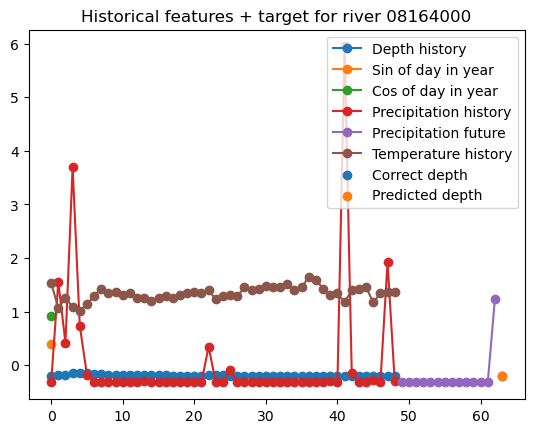

In [153]:
rowIdx = max_error_idx-5
predicted_val = complex_model_conv.predict(x=X_test_df.iloc[[rowIdx], 3:], verbose=0).reshape(-1)
y_point = X_test_df.iloc[rowIdx, :]['y']
all_ds = [f'd{idx}' for idx in range(data_days)]
all_ps = [f'p{idx}' for idx in range(data_days)]
all_ts = [f't{idx}' for idx in range(data_days)]
d_points = X_test_df.iloc[rowIdx, :][all_ds].to_list()
p_points = X_test_df.iloc[rowIdx, :][all_ps].to_list()
t_points = X_test_df.iloc[rowIdx, :][all_ts].to_list()
sin = X_test_df.iloc[rowIdx, :]['year_sin']
cos = X_test_df.iloc[rowIdx, :]['year_cos']
plt.plot(range(data_days), d_points, '-o', label='Depth history')
plt.plot(0,sin, '-o', label='Sin of day in year')
plt.plot(0,cos, '-o', label='Cos of day in year')
plt.plot(range(data_days), p_points, '-o', label='Precipitation history')
future_rain = X_test_df.iloc[rowIdx+future_days, :][all_ps[-future_days:]].to_list()
plt.plot(range(data_days, data_days+future_days), future_rain, '-o', label='Precipitation future')
plt.plot(range(data_days), t_points, '-o', label='Temperature history')
plt.scatter(data_days + future_days, y_point, label='Correct depth')
plt.scatter(data_days + future_days, predicted_val, label='Predicted depth')
plt.legend()
riv_name = X_test_df.iloc[rowIdx, :]['river']
plt.title(f'Historical features + target for river {riv_name}')
plt.savefig(f'./presentation docs/feature_prediction_gone_wrong2.png', dpi=200)
plt.show()

In [62]:
len(range(data_days, data_days+future_days))

14